In [1]:
import models.channel_flow as chan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
torch.random.manual_seed(123)

In [2]:
dns_retau180 = pd.read_csv('../machine-learning-turbulence/data/LM_Channel_Retau180.txt', delimiter=' ')

In [92]:
with open('data/retau180.dat') as f:
    retau_mean = f.readlines()

In [93]:
retau_mean = retau_mean[1:]
retau_mean = list(map(lambda x: x.strip().split(), retau_mean))
retau_mean = [float(elem[2]) for elem in retau_mean]
# retau_mean

In [14]:
hypers = chan.get_hyperparams(ymin=-1, ymax=1, num_epochs=200000, lr=0.0001, 
                              num_layers=4, num_units=40, batch_size=2000)

In [15]:
hypers['nu']=0.005555555555
delta = (hypers['ymax']-hypers['ymin'])/2
reynolds_stress = chan.get_mixing_len_model(hypers['k'], delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Training at Retau={}'.format(retau))

Training at Retau=180.000000018


In [16]:
half_u180,  half_y180 = chan.convert_dns(delta, hypers, dns_retau180)

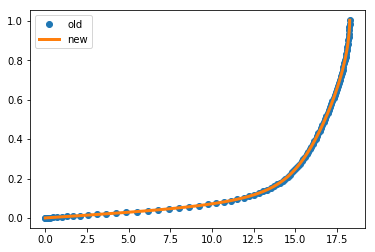

In [94]:
plt.plot(half_u180, half_y180, 'o', label='old')
plt.plot(retau_mean, half_y180, '-', lw=3, label='new')
plt.legend() # verify DNS transform

In [17]:
pdenn180 = chan.Chanflow(num_units=hypers['num_units'], num_layers=hypers['num_layers'])
losses180 = pdenn180.train(hypers['ymin'], hypers['ymax'],
                                   reynolds_stress,
                                   nu=hypers['nu'],
                                   dp_dx=hypers['dp_dx'],
                                   rho=hypers['rho'],
                                   batch_size=hypers['batch_size'],
                                   epochs=hypers['num_epochs'],
                                   lr=hypers['lr'],
                                   C=1)

100%|██████████| 200000/200000 [2:56:08<00:00, 18.92it/s, loss=0.02]  


In [32]:
y = torch.linspace(-1,1,1000).reshape(-1,1)
y = torch.tensor(y, requires_grad=True)
u_bar = pdenn180.predict(y)

## calculate loss
# compute d(\bar{u})/dy
du_dy, = torch.autograd.grad(u_bar, y,
              grad_outputs=u_bar.data.new(u_bar.shape).fill_(1),
              retain_graph=True,
              create_graph=True)

# compute d^2(\bar{u})/dy^2
d2u_dy2, = torch.autograd.grad(du_dy, y,
                grad_outputs=du_dy.data.new(du_dy.shape).fill_(1),
                retain_graph=True,
                create_graph=True)

# compute d<uv>/dy
re = reynolds_stress(y, du_dy)
dre_dy, = torch.autograd.grad(re, y,
               grad_outputs=re.data.new(re.shape).fill_(1),
               retain_graph=True,
               create_graph=True)

# compute loss!
axial_eqn = hypers['nu'] * d2u_dy2 - dre_dy - (1/hypers['rho']) * hypers['dp_dx']
# boundary_pred = self(boundary)
# loss = torch.mean(torch.pow(axial_eqn, 2)) #+ C * torch.mean(torch.pow(boundary_condition - boundary_pred, 2))

In [52]:
u_bar[0], u_bar[-1] # u_bar exactly zero at endpoints

(tensor([0.], grad_fn=<SelectBackward>),
 tensor([0.], grad_fn=<SelectBackward>))

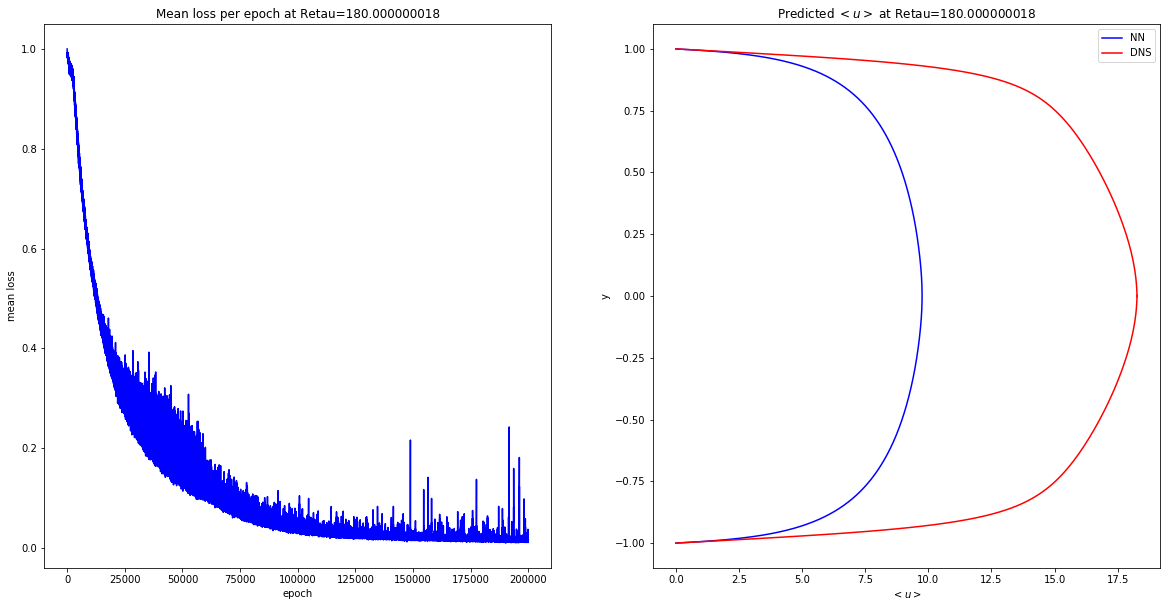

In [81]:
# 2K pts, analytical bcs, 2 hidden, 40 units, lr=0.0001

fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)

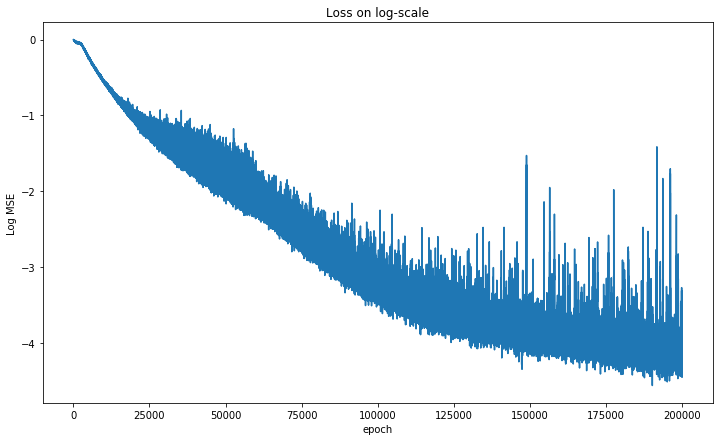

In [58]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(len(losses180)), np.log(losses180))
plt.title('Loss on log-scale')
plt.xlabel('epoch')
plt.ylabel('Log MSE')
plt.show()

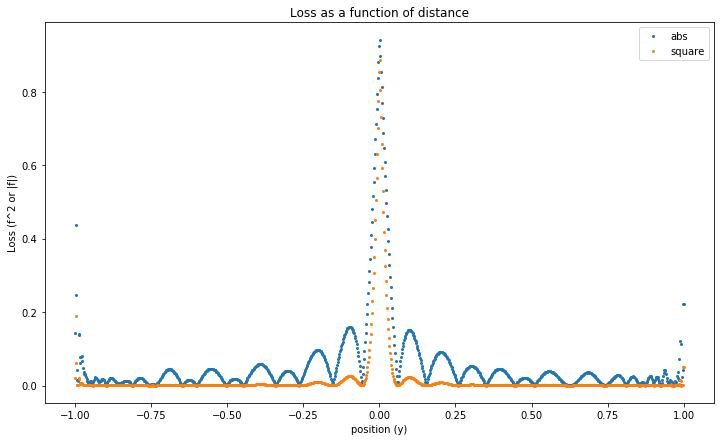

In [98]:
plt.figure(figsize=(12,7))
plt.plot(y.detach().numpy(), np.abs(axial_eqn.detach().numpy()), 'o', markersize=2, lw=0.5, label='abs')
plt.plot(y.detach().numpy(), np.power(axial_eqn.detach().numpy(), 2), 'o', markersize=2, lw=0.5, label='square')
plt.title('Loss as a function of distance')
plt.ylabel('Loss (f^2 or |f|)')
plt.xlabel('position (y)')
plt.legend()
plt.show()

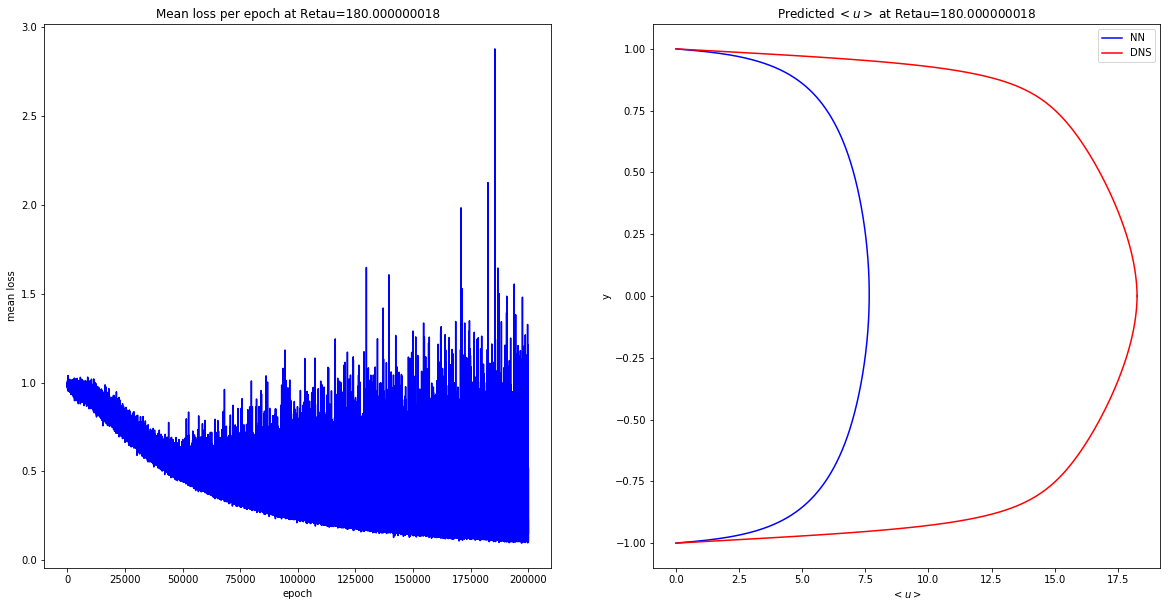

In [9]:
# 100 pts, analytical bcs, 2 hidden, 40 units

fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180, delta)

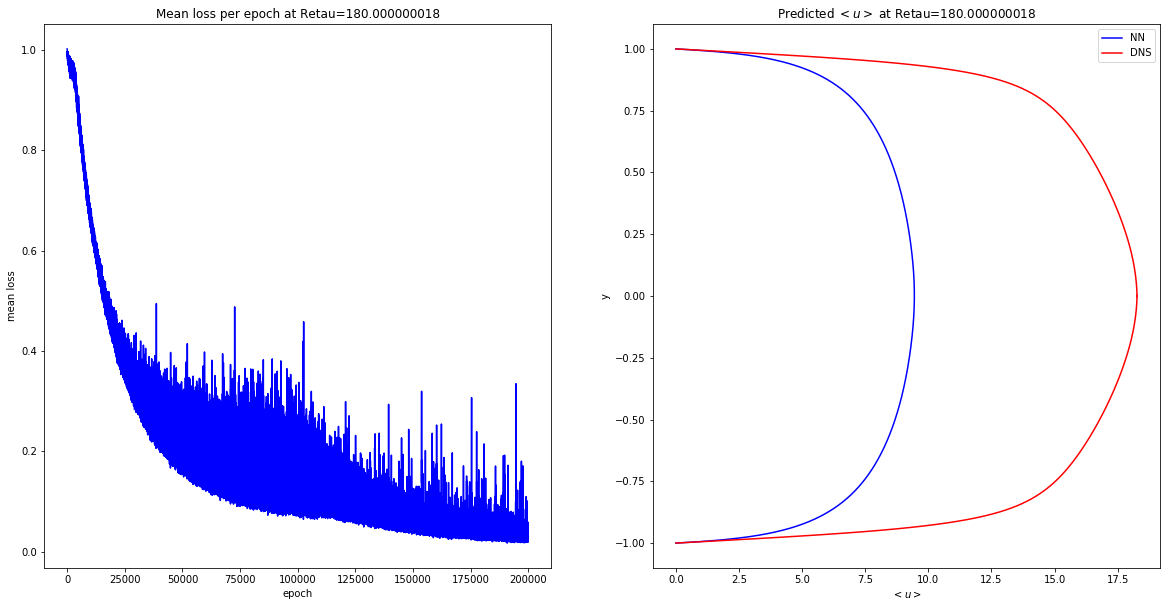

In [30]:
# 1K pts, analytical bcs, 2 hidden, 40 units

fig, ax = plt.subplots(1, 2, figsize=(20,10))
delta=1
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
# chan.plot_dns(ax[1], half_u180, half_y180)
ax[1].plot(half_u180, half_y180-1, color='red', label='DNS')
ax[1].plot(half_u180, -half_y180+2*delta-1, color='red')
ax[1].legend()

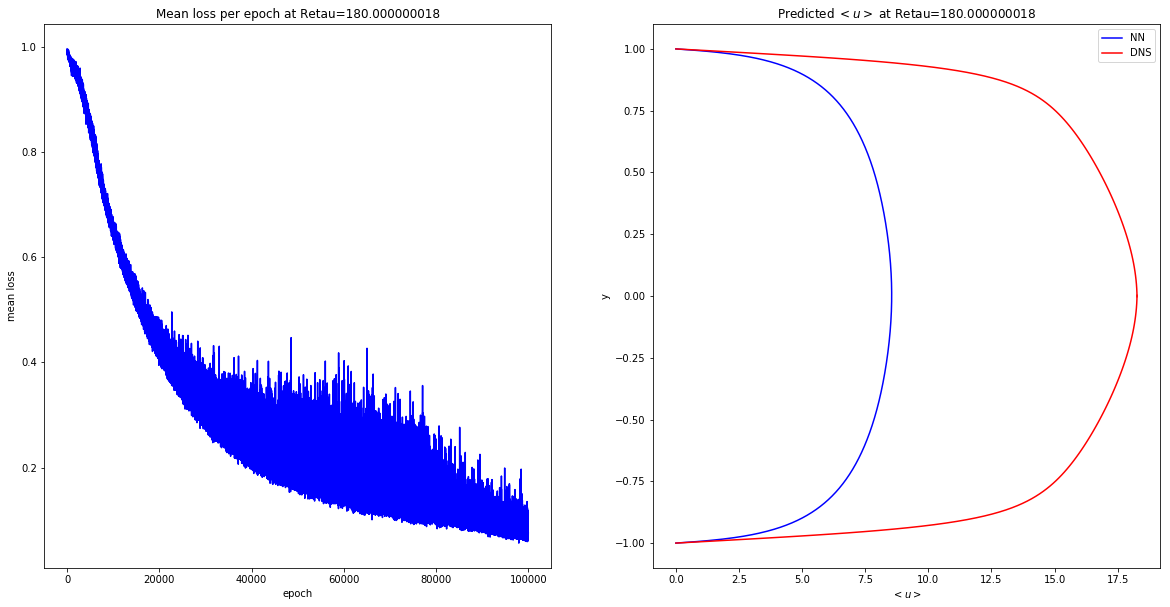

In [15]:
# 1K pts, analytical bcs, 2 hidden, 40 units

fig, ax = plt.subplots(1, 2, figsize=(20,10))
delta=1
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
# chan.plot_dns(ax[1], half_u180, half_y180)
ax[1].plot(half_u180, half_y180-1, color='red', label='DNS')
ax[1].plot(half_u180, -half_y180+2*delta-1, color='red')
ax[1].legend()

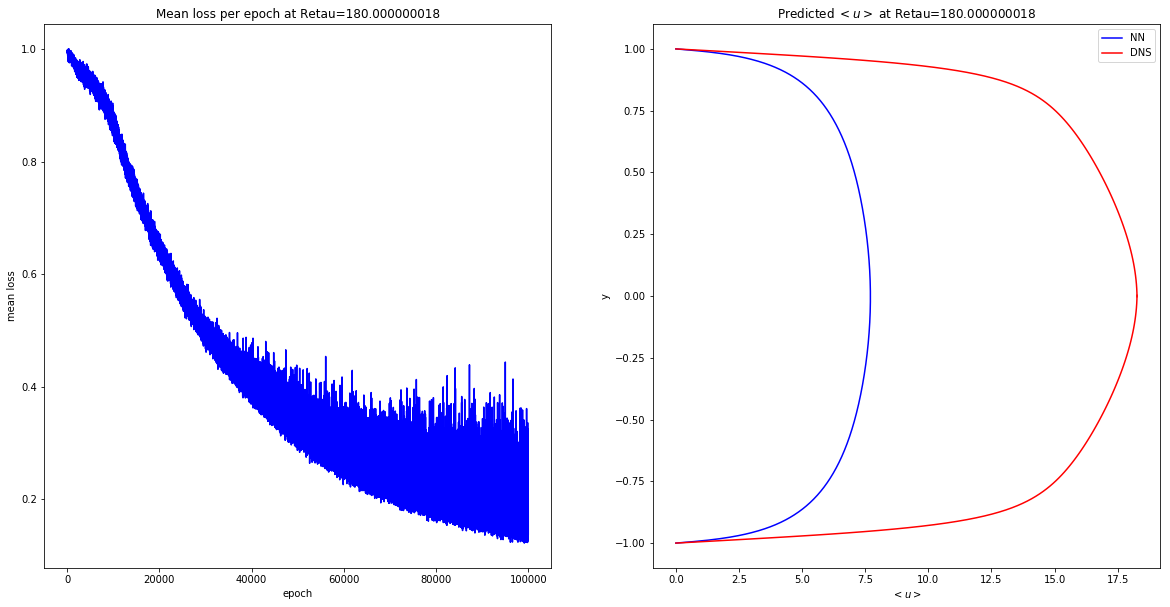

In [14]:
# 1K pts, analytical bcs, 2 hidden, 20 units

fig, ax = plt.subplots(1, 2, figsize=(20,10))
chan.make_plots(ax, losses180, pdenn180, hypers, retau)
chan.plot_dns(ax[1], half_u180, half_y180)